## Polygon AutoEncoder

In [1]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from utils.prepare_dataset import prepare_dataset_mnist

/home/dingkang/envs/nlp_a4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_GPU = True if torch.cuda.is_available() else "cpu"

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_dim, max_seq_len):
        super().__init__()

        pe = torch.zeros(max_seq_len, emb_dim)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_dim, 2).float() * -(math.log(10000.0) / emb_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        if emb_dim % 2 == 0:
            pe[:, 1::2] = torch.cos(position * div_term)
        else:
            pe[:, 1::2] = torch.cos(position * div_term)[:, :-1] # Avoid dismatch dimension for odd d_model
        self.register_buffer('pe', pe.unsqueeze(0))
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


In [134]:
class Pae(nn.Module):
    def __init__(self, fea_dim, d_model, num_heads, ffn_dim, num_layers, dropout, max_seq_len):
        super().__init__()

        self.cls_emb = nn.Parameter(torch.randn(1, 1, d_model))
        self.enc_layers = nn.ModuleList([nn.TransformerEncoderLayer(d_model=d_model,
                                                                    nhead=num_heads,
                                                                    dim_feedforward=ffn_dim,
                                                                    dropout=dropout,
                                                                    batch_first=True) for _ in range(num_layers)])
        self.dec_layers = nn.ModuleList([nn.TransformerEncoderLayer(d_model=d_model,
                                                                    nhead=num_heads,
                                                                    dim_feedforward=ffn_dim,
                                                                    dropout=dropout,
                                                                    batch_first=True) for _ in range(num_layers)])
        self.pos_emb = PositionalEncoding(d_model, max_seq_len+1)
        # self.pos_emb = nn.Parameter(torch.randn(1, 1 + max_seq_len, emb_dim))

        self.projection1 = nn.Linear(fea_dim, d_model)
        self.projection2 = nn.Linear(d_model, fea_dim)

        self.mse_loss_func = nn.MSELoss()
        self.meta_loss_func = nn.CrossEntropyLoss()

    def forward(self, x, mask=None):
        input = self.projection1(x)
        class_emb = self.cls_emb.repeat(input.size(0), 1, 1)
        input = torch.cat([class_emb, input], dim=1)
        input = self.pos_emb(input)

        if mask is not None:
            cls_mask = torch.zeros((x.size(0), 1), dtype=torch.bool)
            mask = torch.cat((cls_mask, mask), dim=1)

        hidden = input
        for enc_layer in self.enc_layers:
            hidden = enc_layer(hidden, src_key_padding_mask=mask)
        
        decoded = hidden    # hidden vector here is of high dimension, we can flatten and PCA to get a lower dimension

        for dec_layer in self.dec_layers:
            decoded = dec_layer(decoded, src_key_padding_mask=mask)
        
        decoded = decoded[:, 1:, :] # remove cls decoded token
        decoded = self.projection2(decoded)

        coord_output = decoded[:, :, :2]
        meta_output1 = decoded[:, :, 2:4]
        meta_output2 = decoded[:, :, 4:]
        target_meta1 = torch.argmax(x[:, :, 2:4], dim=-1) # inner or outer points
        target_meta2 = torch.argmax(x[:, :, 4:], dim=-1) # render one-hot code
        coord_loss = self.mse_loss_func(coord_output, x[:, :, :2])
        # 2 is inner or outer one-hot vocab size, 3 is render one-hot vocab size
        meta_loss1 = self.meta_loss_func(meta_output1.contiguous().view(-1, 2), target_meta1.contiguous().view(-1))
        meta_loss2 = self.meta_loss_func(meta_output2.contiguous().view(-1, 3), target_meta2.contiguous().view(-1))

        meta_indices1 = torch.argmax(meta_output1, dim=-1)
        meta_indices2 = torch.argmax(meta_output2, dim=-1)
        output = torch.cat([coord_output, nn.functional.one_hot(meta_indices1, 2), nn.functional.one_hot(meta_indices2, 3)], dim=-1)

        return hidden[:, 1:, :], output, coord_loss*0.25 + (meta_loss1 + meta_loss2)*0.75

In [86]:
max_seq_len = 64
batch_size = 64
dataset_size = 2000
with_mask = False

train_tokens, train_labels, train_mask, val_tokens, val_labels, val_mask = prepare_dataset_mnist(file="dataset/mnist_polygon_train_10k.csv",
                                                                                                 with_mask=with_mask,
                                                                                                 split_ratio=0.2,
                                                                                                 dataset_size=dataset_size,
                                                                                                 max_seq_len=max_seq_len,
                                                                                                 train=True)

test_tokens, test_labels, test_mask = prepare_dataset_mnist(file="dataset/mnist_polygon_test_2k.csv",
                                                            with_mask=with_mask,
                                                            max_seq_len=max_seq_len,
                                                            dataset_size=500,
                                                            train=False)

train_loader = DataLoader(TensorDataset(train_tokens, train_labels, train_mask), batch_size=batch_size, shuffle=True)

In [135]:
pae = Pae(fea_dim=7, d_model=32, num_heads=8, num_layers=1, max_seq_len=64, ffn_dim=64, dropout=0.1)

if USE_GPU:
    pae = pae.to(device)

optimizer = optim.Adam(pae.parameters(), lr=0.004, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001)

num_epoch = 30
for epoch in range(num_epoch):
    pae.train()
    total_loss = 0.0
    for inputs, labels, mask in train_loader:
        optimizer.zero_grad()
        train_hidden, train_outputs, loss = pae(inputs, mask)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    train_loss = total_loss/len(train_loader)

    pae.eval()
    with torch.no_grad():
        val_hidden, val_outputs, loss = pae(val_tokens, val_mask)
        val_loss = loss.item()
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")

pae.eval()
with torch.no_grad():
    test_hidden, test_outputs, loss = pae(test_tokens, test_mask)
    test_loss = loss.item()
print(f"Test Loss: {test_loss}")

Epoch 1, Train Loss: 0.6186462068557739, Val Loss: 0.18094876408576965
Epoch 2, Train Loss: 0.1358567801117897, Val Loss: 0.08084122836589813
Epoch 3, Train Loss: 0.06006619721651077, Val Loss: 0.022772585973143578
Epoch 4, Train Loss: 0.021847021356225012, Val Loss: 0.006497647147625685
Epoch 5, Train Loss: 0.010461425185203552, Val Loss: 0.0031613437458872795
Epoch 6, Train Loss: 0.0066372471675276755, Val Loss: 0.002075562486425042
Epoch 7, Train Loss: 0.004833356402814388, Val Loss: 0.0014729414833709598
Epoch 8, Train Loss: 0.0037173604406416415, Val Loss: 0.0011691749095916748
Epoch 9, Train Loss: 0.002865113774314523, Val Loss: 0.0008913188939914107
Epoch 10, Train Loss: 0.0022996158991008997, Val Loss: 0.0008725750958546996
Epoch 11, Train Loss: 0.0018512923177331686, Val Loss: 0.0006089010275900364
Epoch 12, Train Loss: 0.0015222759917378425, Val Loss: 0.0005812560557387769
Epoch 13, Train Loss: 0.0012571803806349635, Val Loss: 0.00045594500261358917
Epoch 14, Train Loss: 0.00

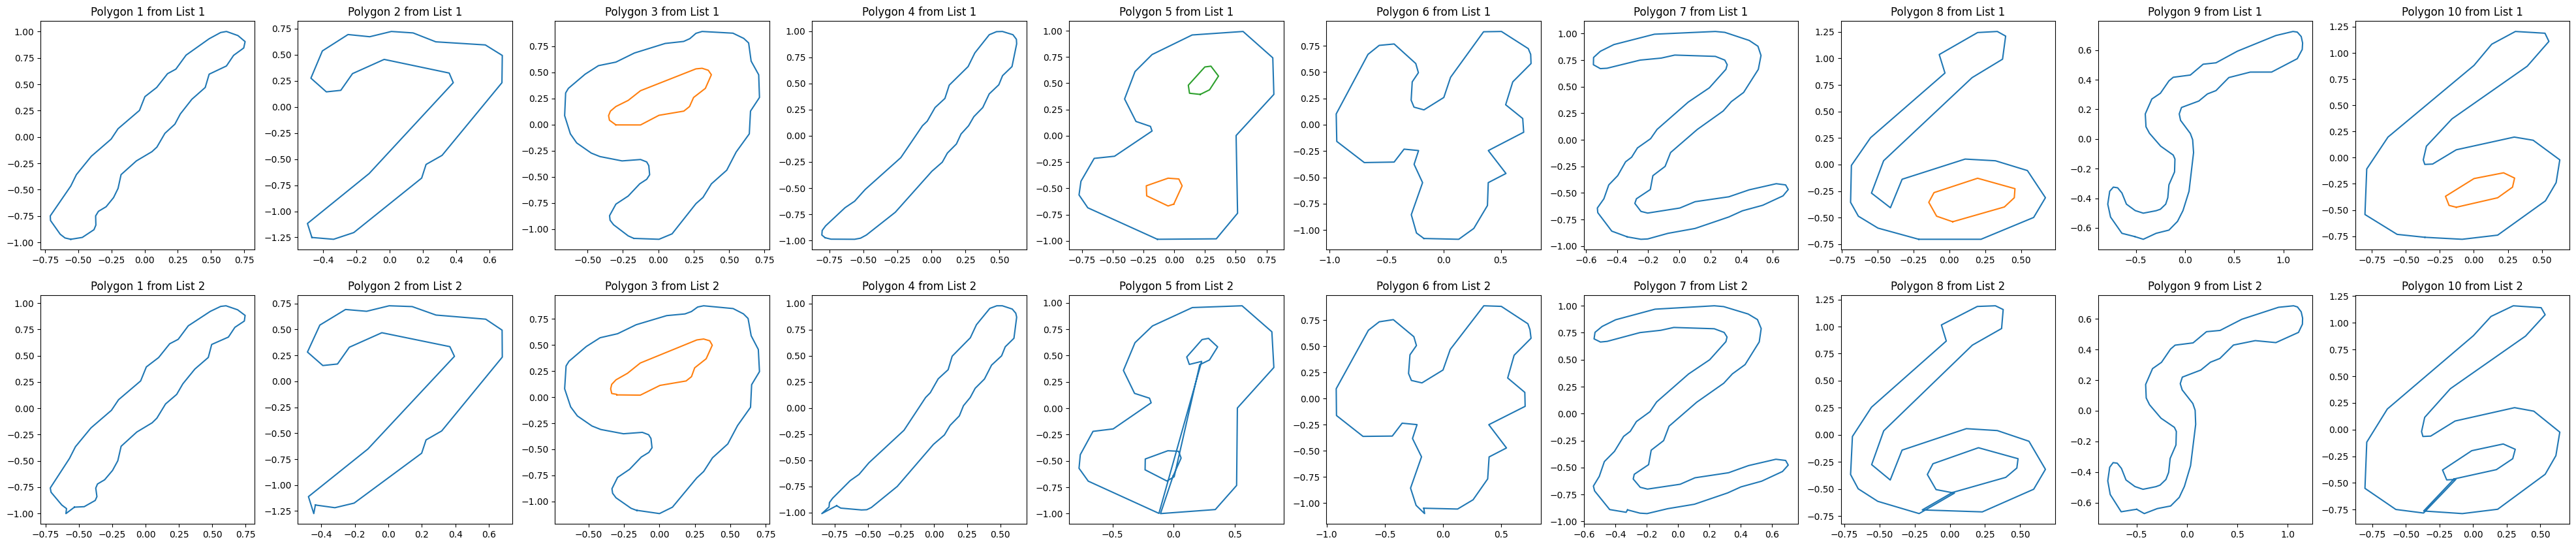

In [136]:
from utils.vector2shape import reverse_vector_polygon
import matplotlib.pyplot as plt

show_tokens = val_tokens[:10]

pae.eval()
with torch.no_grad():
    show_hidden, show_outputs, _ = pae(show_tokens)

num_samples = 10
ori_polygons = [reverse_vector_polygon(token) for token in show_tokens]
new_polygons = [reverse_vector_polygon(token) for token in show_outputs]

# Create a figure with subplots for each polygon
fig, axs = plt.subplots(2, num_samples, figsize=(5*num_samples, 10))

# Plot polygons from the first list
for i, polygon in enumerate(ori_polygons):
    axs[0, i].set_title('Polygon {} from List 1'.format(i+1))
    x, y = polygon.exterior.xy
    axs[0, i].plot(x, y)
    holes_x = [[coord[0] for coord in interior.coords] for interior in polygon.interiors]
    holes_y = [[coord[1] for coord in interior.coords] for interior in polygon.interiors]
    if holes_x:
        for hole_x, hole_y in zip(holes_x, holes_y):
            axs[0, i].plot(hole_x, hole_y)

# Plot polygons from the second list
for i, polygon in enumerate(new_polygons):
    axs[1, i].set_title('Polygon {} from List 2'.format(i+1))
    x, y = polygon.exterior.xy
    axs[1, i].plot(x, y)
    holes_x = [[coord[0] for coord in interior.coords] for interior in polygon.interiors]
    holes_y = [[coord[1] for coord in interior.coords] for interior in polygon.interiors]
    if holes_x:
        for hole_x, hole_y in zip(holes_x, holes_y):
            axs[1, i].plot(hole_x, hole_y)

# Show the plot
plt.show()

In [137]:
val_hidden.shape

torch.Size([400, 64, 32])

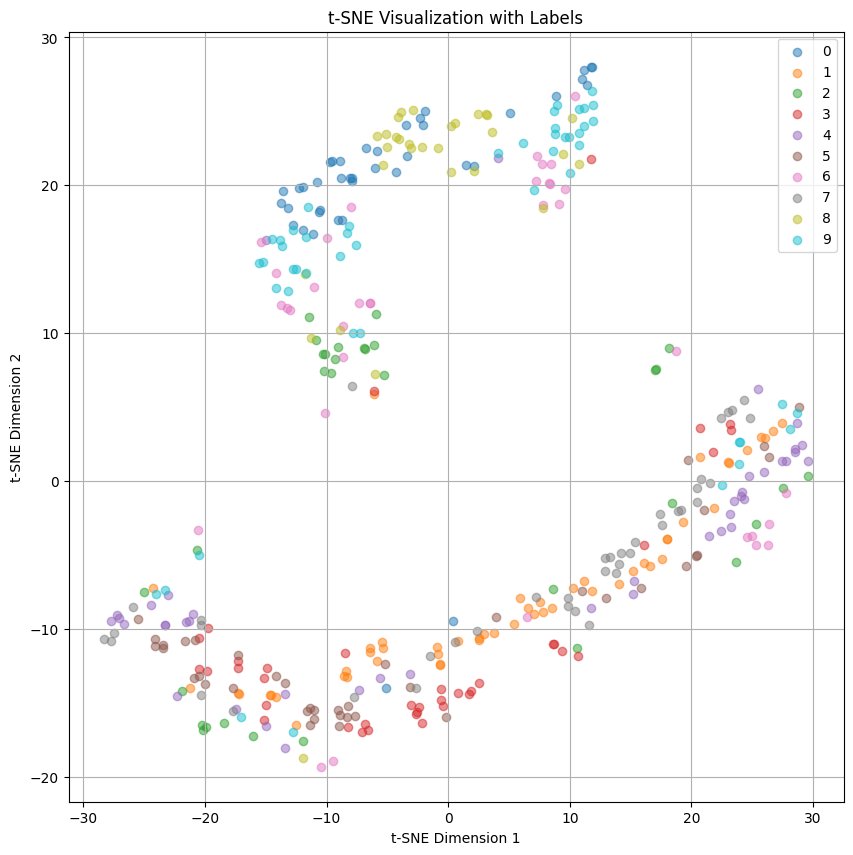

In [143]:
# show_hidden = val_tokens.view(val_tokens.size(0), -1)
show_hidden = val_hidden.view(val_hidden.size(0), -1)
show_labels = val_labels


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np


tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(show_hidden)

plt.figure(figsize=(10, 10))

# Plot each class separately
for label in np.unique(show_labels):
    indices = show_labels == label
    plt.scatter(projections[indices, 0], projections[indices, 1], label=label, alpha=0.5)

plt.title('t-SNE Visualization with Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

In [141]:
with torch.no_grad():
    train_hidden = pae(train_tokens, train_mask)[0].view(train_tokens.size(0), -1)
    val_hidden = pae(val_tokens, val_mask)[0].view(val_tokens.size(0), -1)

    tsne = PCA(n_components=64, random_state=0)
    train_hidden = torch.tensor(tsne.fit_transform(train_hidden), dtype=torch.float32)
    val_hidden = torch.tensor(tsne.transform(val_hidden), dtype=torch.float32)

# tsne = PCA(n_components=64, random_state=0)
# train_hidden = torch.tensor(tsne.fit_transform(train_tokens.view(train_tokens.size(0), -1)), dtype=torch.float32)
# val_hidden = torch.tensor(tsne.transform(val_tokens.view(val_tokens.size(0), -1)), dtype=torch.float32)


# train_hidden = train_tokens.view(train_tokens.size(0), -1)
# val_hidden = val_tokens.view(val_tokens.size(0), -1)

cls_train_loader = DataLoader(TensorDataset(train_hidden, train_labels), batch_size=32, shuffle=True)

In [145]:
# Define the classifier
class Classifier(nn.Module):
    def __init__(self, input_size, dense_size, num_classes, dropout):
        super().__init__()
        self.dense1 = nn.Linear(input_size, dense_size)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(dense_size, num_classes)

    def forward(self, x):
        # x = self.relu(self.dense1(x))
        # x = self.dropout(x)
        # x = self.dense2(x)
        # Linear probing
        x = self.dense1(x)
        return x
    
classifier = Classifier(train_hidden.size(1), 128, 10, 0.0)

if USE_GPU:
    classifier = classifier.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.004)
# optimizer = optim.Adam(classifier.parameters(), lr=0.004, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001)

num_epochs = 30

def train(model, loader):
    model.eval()
    train_loss = 0.0
    correct = 0
    total = 0
    for batch_x, batch_y in loader:
        if USE_GPU:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, dim=-1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    train_loss /= len(loader)
    train_acc = correct / total
    return train_loss, train_acc

def evaluate(model, tokens, labels):
    model.eval()
    with torch.no_grad():
        if USE_GPU:
            tokens, labels = tokens.to(device), labels.to(device)
        outputs = model(tokens)
        eval_loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, dim=-1)
        eval_acc = (predicted == labels).sum().item() / labels.size(0)
    return eval_loss, eval_acc

for epoch in range(num_epochs):
    train_loss, train_acc = train(classifier, cls_train_loader)
    val_loss, val_acc = evaluate(classifier, val_hidden, val_labels)
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss}, Train Acc {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}")


# # Test
# test_loss, test_acc = evaluate(classifier, test_loader)
# print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")

Epoch: 1, Train Loss: 4.006747069358826, Train Acc 0.26125, Val Loss: 2.820640802383423, Val Acc: 0.51
Epoch: 2, Train Loss: 2.2133633708953857, Train Acc 0.584375, Val Loss: 1.8195728063583374, Val Acc: 0.6675
Epoch: 3, Train Loss: 1.565259518623352, Train Acc 0.69375, Val Loss: 1.4979101419448853, Val Acc: 0.7275
Epoch: 4, Train Loss: 1.3216706144809722, Train Acc 0.723125, Val Loss: 1.360314965248108, Val Acc: 0.74
Epoch: 5, Train Loss: 1.197429381608963, Train Acc 0.73875, Val Loss: 1.2935912609100342, Val Acc: 0.755
Epoch: 6, Train Loss: 1.1206153452396392, Train Acc 0.74125, Val Loss: 1.2501487731933594, Val Acc: 0.755
Epoch: 7, Train Loss: 1.0678114593029022, Train Acc 0.758125, Val Loss: 1.2243083715438843, Val Acc: 0.7475
Epoch: 8, Train Loss: 1.0263834619522094, Train Acc 0.76, Val Loss: 1.2023060321807861, Val Acc: 0.745
Epoch: 9, Train Loss: 0.9935162675380707, Train Acc 0.765625, Val Loss: 1.1882452964782715, Val Acc: 0.745
Epoch: 10, Train Loss: 0.9671072441339493, Train 